# Importing Libraries

In [4]:
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from kneed import KneeLocator
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing, decomposition
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline 

%matplotlib inline
np.random.seed(1)
warnings.filterwarnings('ignore')

# Loading Data

In [5]:
a_train=pd.read_csv("Train.csv")
a_train
b_test=pd.read_csv("Test.csv")
b_test
print(f'\nTrain data shape - {a_train.shape}')
print(f'Test data shape - {b_test.shape} \n')


Train data shape - (8068, 11)
Test data shape - (2627, 10) 



In [6]:
a_train.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B


In [7]:
b_test.head(3)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6


# General Info of Data

In [8]:
a_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


# Most of the data types are object so we need to convert them into numerical variables.

In [9]:
a_train.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [10]:
b_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            2595 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 205.4+ KB


In [11]:
b_test.describe()

,ID,Age,Work_Experience,Family_Size
count,2627.000000,2627.000000,2358.000000,2514.000000
mean,463433.918919,43.649791,2.552587,2.825378
std,2618.245698,16.967015,3.341094,1.551906
min,458989.000000,18.000000,0.000000,1.000000
25%,461162.500000,30.000000,0.000000,2.000000
50%,463379.000000,41.000000,1.000000,2.000000
75%,465696.000000,53.000000,4.000000,4.000000
max,467968.000000,89.000000,14.000000,9.000000


# Data cleaning

Check if we have duplicate applicants

In [12]:
duplicates = a_train[a_train.duplicated(subset = a_train.columns.drop("Segmentation"))]
duplicates

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation


# Check for null values in the data

In [13]:
train_without_nan = len(a_train.drop(columns ="Segmentation").dropna())
test_without_nan = len(b_test.dropna())
print(f"\nPercentage of applicants who have at least one null feature - TRAIN - {(1-train_without_nan/len(a_train))*100}")
print(f"Percentage of applicants who have at least one null feature - TEST -  {(1-test_without_nan/len(b_test))*100}\n")


Percentage of applicants who have at least one null feature - TRAIN - 17.389687654933073
Percentage of applicants who have at least one null feature - TEST -  18.00532927293491



In [14]:
null_a = pd.concat([pd.DataFrame(a_train.isna().sum()),pd.DataFrame(b_test.isna().sum())],axis=1)
null_a.columns = ["Train_Nan","Test_Nan"]
null_a

,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,140,50.0
Age,0,0.0
Graduated,78,24.0
Profession,124,38.0
Work_Experience,829,269.0
Spending_Score,0,0.0
Family_Size,335,113.0
Var_1,76,32.0


# As we see null values are 17% of our data so we can't drop them we need to fill. But I have to drop applicants who have 3 or more null features because if I fill them they will not be accurate. Here is the percentage of such applicants.

Let's check percentage of applicants who have 3 or more null features

In [15]:
print(f"\nPercentage of applicants who have 3 or more null feature - TRAIN - \
{len(a_train.loc[a_train.isnull().sum(axis=1)>=3])/len(a_train)*100}")

print(f"Percentage of applicants who have 3 or more null feature - TEST  - \
{len(b_test.loc[b_test.isnull().sum(axis=1)>=3])/len(b_test)*100}")


Percentage of applicants who have 3 or more null feature - TRAIN - 0.23549826474962818
Percentage of applicants who have 3 or more null feature - TEST  - 0.22839741149600304


As we see the number of such applicants is 0.2 percent of our data so we can drop them

# Data visualization
Let's see distribution of categorical features which have 2 or 3 categories

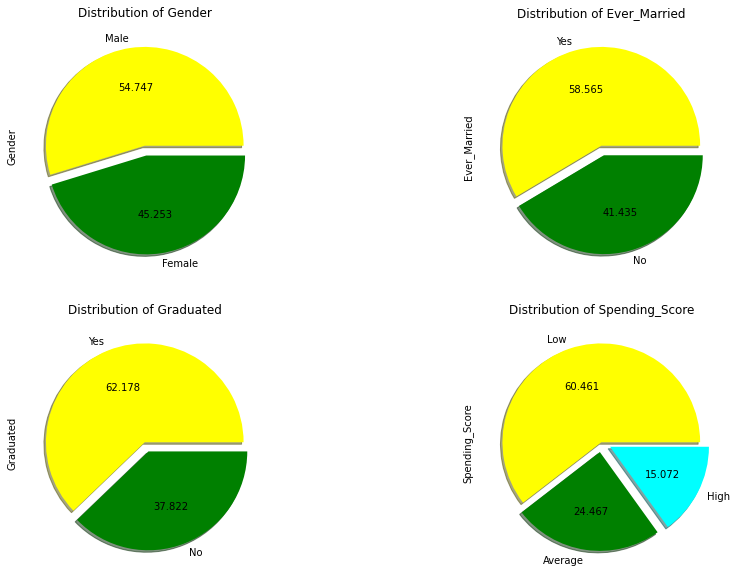

In [16]:
p, ax  = plt.subplots(2,2,figsize = (15,10))
colors=["yellow", "green","cyan"]
a_train['Gender'].value_counts().plot.pie(title='Distribution of Gender',explode=[0,.1],
                                          ax=ax[0][0],autopct="%.3f",shadow = True,colors = colors)

a_train['Ever_Married'].value_counts().plot.pie(title='Distribution of Ever_Married',explode=[0,.1],
                                                 ax=ax[0][1],autopct="%.3f",shadow = True,colors = colors)

a_train['Graduated'].value_counts().plot.pie(title='Distribution of Graduated',explode=[0,.1],
                                              ax=ax[1][0],autopct="%.3f",shadow = True,colors = colors)

a_train['Spending_Score'].value_counts().plot.pie(title='Distribution of Spending_Score',
                                                ax=ax[1][1],explode=[0,.1,.1],autopct="%.3f",shadow = True,colors=colors)
p.patch.set_facecolor('white')
plt.show()

# From these plots we can determine that:
1. Most of our patients are men
2. People who are graduated
3. Who are Ever married
4. Who have low Spending score

Let's see distribution other categorical features which have a little more categories so I plot them by countplot

<AxesSubplot:xlabel='Var_1', ylabel='count'>

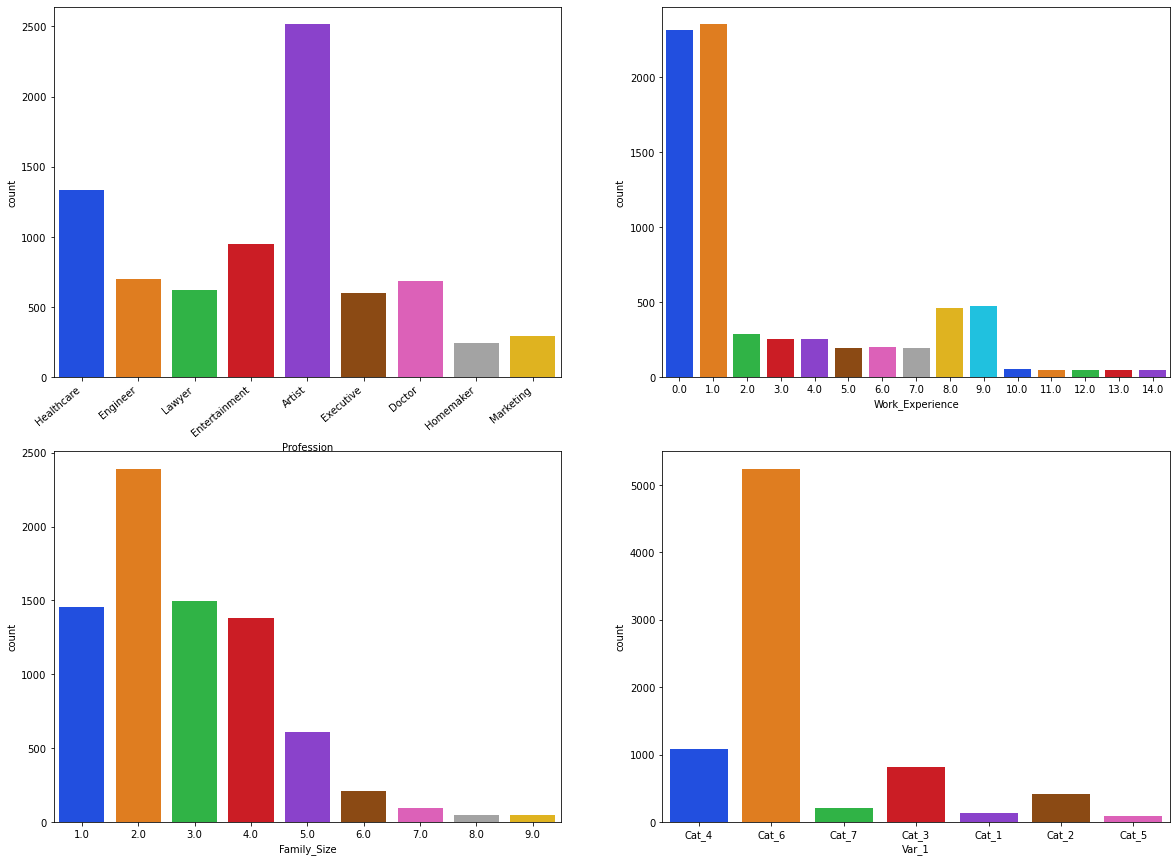

In [17]:
p, ax  = plt.subplots(2,2,figsize = (20,15))
colors=["#023EFF","#FF7C00", "#E8000B","#1AC938"]
labels = ["D","C","A","B"]

ax1 = sns.countplot(a_train['Profession'],ax=ax[0][0],palette = "bright")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")

sns.countplot(a_train['Work_Experience'],ax=ax[0][1],palette = "bright")
sns.countplot(a_train['Family_Size'],ax=ax[1][0],palette = "bright")
sns.countplot(a_train['Var_1'],ax=ax[1][1],palette = "bright")

# From these plots we can determine that:
1. Most of our patients are Artist
2. People who have a little work experience
3. Who has 1 family member
4. Most of them are from 6 category

Let's see distribution of Age which is our only numerical data

In [18]:
def createPlot(data, col:str, ttext:str, xtext:str, ytext:str) ->None:
    """
    this function creates histogram and boxplot by pyplot library and also count skewness
    
    Arguments:
    data -- pandas dataframe
    col -- column name which we want to plot
    ttext -- string which we want to write on top of the graph
    xtext -- string which we want to write on x axis
    ytext -- string which we want to write on y axis
    
    Returns:
    None
    """
    plotly.offline.init_notebook_mode(connected=True)
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=1,col=1)
    fig.add_trace(go.Box(x=data[col]),row=1,col=2)
    
    fig.update_layout(
        title_text=ttext,
        xaxis_title_text=xtext,
        yaxis_title_text=ytext, 
        bargap=0.05, 
        template = 'plotly_dark',
        width=900, height=600
    )
    
    fig.show()

In [19]:
createPlot(a_train,"Age","Age distribution","Age","count")

# We can see that most of our applicants are in middle age median is 41.
Also we don't have applicants in this age 24 34 44 54 64 it's a little surprising why minimum age is 18 and maximum 89.

# Class Distribution
Also see if the distribution of classes has imbalance

<AxesSubplot:xlabel='Segmentation', ylabel='count'>

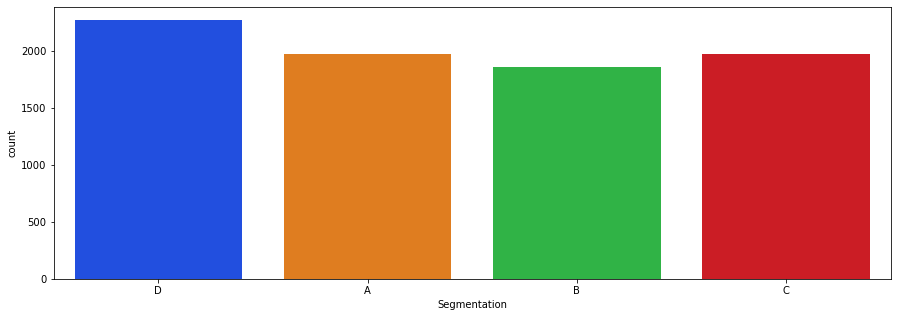

In [20]:
p, ax = plt.subplots(figsize=(15, 5))

sns.countplot(a_train['Segmentation'],palette = "bright")

# So our data data is not unbalanced

# Data preparation

Label encoding

Before we do the label encoding let’s look at the data

In [21]:
a_train.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [22]:
def get_encoded_dict(a,lst):
    """
    this function creates dictionary for encoding. Its find unique labels for each column and enumerate them
    
    Arguments:
    df -- pandas dataframe
    lst -- list of columns which we want to encode 
    
    Returns:
    dictionary where key is column name and value is dictionary of unique labels and encoding value
    """
    encoded_dict = {}
    for col in lst:
        each_dict = {}
        sorted_unique_names = a[col].dropna().unique()
        sorted_unique_names.sort()
        for i,val in enumerate(sorted_unique_names):
            each_dict[val] = i
        encoded_dict[col] = each_dict
    return encoded_dict

In [23]:
encoded_dict = get_encoded_dict(a_train,["Gender","Ever_Married","Graduated","Profession",
                                         "Spending_Score","Var_1","Segmentation"])

duplicates = duplicates.replace(encoded_dict)

a_train = a_train.replace(encoded_dict)
b_test = b_test.replace(encoded_dict)

In [24]:
a_train.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1,0.0,22,0.0,5.0,1.0,2,4.0,3.0,3
1,462643,0,1.0,38,1.0,2.0,NaN,0,3.0,3.0,0
2,466315,0,1.0,67,1.0,2.0,1.0,2,1.0,5.0,1
3,461735,1,1.0,67,1.0,7.0,0.0,1,2.0,5.0,1
4,462669,0,1.0,40,1.0,3.0,NaN,1,6.0,5.0,0


As we can see the data consists only numbers

# Handle Missing Data

First of all we need to drop applicants who have 3 or more null features

In [25]:
print(f"Train data shape before {a_train.shape}")
print(f"Test  data shape before {b_test.shape}")

a_train = a_train.loc[a_train.drop(columns = "Segmentation").isnull().sum(axis=1)<3]
b_test = b_test.loc[b_test.isnull().sum(axis=1)<3]

print(f"\nTrain data shape after {a_train.shape}")
print(f"Test  data shape after {b_test.shape}")

Train data shape before (8068, 11)
Test  data shape before (2627, 10)

Train data shape after (8049, 11)
Test  data shape after (2621, 10)


# Now we need to fill other null values. We have several methods for this:



1. Using (Mean/Median) Values
2. Using (Most Frequent) or (Zero/Constant) Values
3. Using k-NN

In this case I will use k-NN method because we don't have big data so it will work fast and it consider that we may have similar data

First let's see how many Nan values we have

In [26]:
null_df = pd.concat([pd.DataFrame(a_train.isna().sum()),pd.DataFrame(b_test.isna().sum())],axis=1)
null_df.columns = ["Train_Nan","Test_Nan"]
null_df

,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,134,48.0
Age,0,0.0
Graduated,72,23.0
Profession,113,35.0
Work_Experience,813,264.0
Spending_Score,0,0.0
Family_Size,320,109.0
Var_1,72,29.0


In [27]:
imputer = KNNImputer()

a_train[a_train.columns.drop(["ID","Segmentation"])] = np.round(imputer.fit_transform(a_train.drop(columns = ["ID","Segmentation"])))
b_test[b_test.columns.drop(["ID"])] = np.round(imputer.fit_transform(b_test.drop(columns = ["ID"])))

In [28]:
null_df = pd.concat([pd.DataFrame(a_train.isna().sum()),pd.DataFrame(b_test.isna().sum())],axis=1)
null_df.columns = ["Train_Nan","Test_Nan"]
null_df

,Train_Nan,Test_Nan
ID,0,0.0
Gender,0,0.0
Ever_Married,0,0.0
Age,0,0.0
Graduated,0,0.0
Profession,0,0.0
Work_Experience,0,0.0
Spending_Score,0,0.0
Family_Size,0,0.0
Var_1,0,0.0


As we saw now we don't have Nan values

# Min-Max normalization

Before we do Min-Max normalization let’s look at the data

In [29]:
a_train.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1.0,0.0,22.0,0.0,5.0,1.0,2.0,4.0,3.0,3
1,462643,0.0,1.0,38.0,1.0,2.0,5.0,0.0,3.0,3.0,0
2,466315,0.0,1.0,67.0,1.0,2.0,1.0,2.0,1.0,5.0,1
3,461735,1.0,1.0,67.0,1.0,7.0,0.0,1.0,2.0,5.0,1
4,462669,0.0,1.0,40.0,1.0,3.0,5.0,1.0,6.0,5.0,0


Ever_Married
1.0    4700
0.0    3349
Name: Ever_Married, dtype: int64


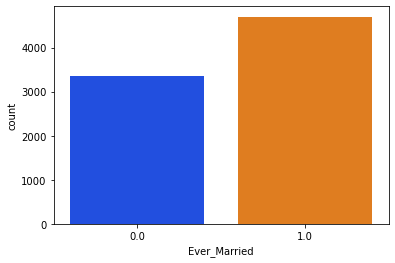

In [30]:
print('Ever_Married')
print(a_train["Ever_Married"].value_counts())
sns.countplot(x='Ever_Married', data=a_train, palette='bright')
plt.show()

In [31]:
scaler = MinMaxScaler()
columns_to_normalize = ['Age','Profession','Work_Experience','Spending_Score','Family_Size','Var_1']

a_train[columns_to_normalize] = scaler.fit_transform(a_train[columns_to_normalize])
b_test[columns_to_normalize] = scaler.fit_transform(b_test[columns_to_normalize])

a_train.head(5)

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,1.0,0.0,0.056338,0.0,0.625,0.071429,1.0,0.375,0.500000,3
1,462643,0.0,1.0,0.281690,1.0,0.250,0.357143,0.0,0.250,0.500000,0
2,466315,0.0,1.0,0.690141,1.0,0.250,0.071429,1.0,0.000,0.833333,1
3,461735,1.0,1.0,0.690141,1.0,0.875,0.000000,0.5,0.125,0.833333,1
4,462669,0.0,1.0,0.309859,1.0,0.375,0.357143,0.5,0.625,0.833333,0


As we saw now we have all value in range 0-1

# Let’s look correlation matrix

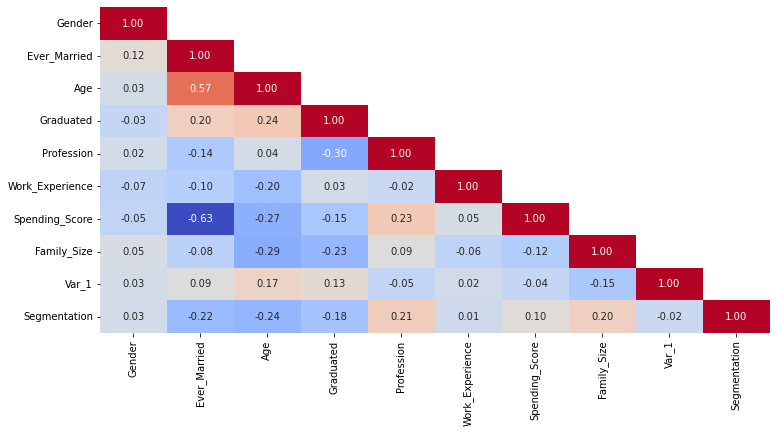

In [32]:
matrix = a_train.drop(columns=["ID"]).corr()
p, ax = plt.subplots(figsize=(12, 6))
with sns.axes_style("white"):
    sns.heatmap(matrix,mask=np.triu(matrix,1),annot=True,fmt=".2f", vmax=.8,cbar=False,cmap="coolwarm");

# As we see "Ever_Married" and "Spending_Score" are high correlated so we need one of them

# Classification

Before we do Classification let’s choose Classification and Reporting variables

Plot bar charts which will show feature importance.

For this plot I will use Decision Trees which is one of the most appropriate method for this kind of finding.

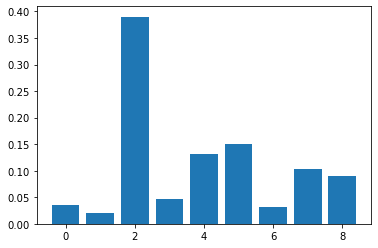

In [33]:
X_train, X_test, y_train, y_test = train_test_split(a_train.drop(columns=["ID","Segmentation"])
                                    ,a_train["Segmentation"], test_size=0.3, random_state=42,)
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
importance = model.feature_importances_
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [34]:
X_train.head(5)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
5574,1.0,1.0,0.690141,1.0,0.750,0.071429,0.0,0.125,0.166667
4520,0.0,1.0,0.478873,1.0,0.250,0.285714,1.0,0.000,0.333333
4808,1.0,1.0,0.211268,0.0,0.500,0.214286,0.5,0.375,0.833333
2865,0.0,0.0,0.464789,1.0,0.000,0.000000,1.0,0.000,0.833333
1006,0.0,1.0,0.619718,1.0,0.875,0.000000,1.0,0.125,0.833333


From this plot we can find the least important variable which is "Ever_Married".

But I think we can't drop it because as we saw in correlation matrix "Ever_Married" and "Spending_Score" are high correlated.

So we need to leave one of them.

I will use "Gender" and "Spending_Score" in reporting variables.

# Now we can create a model
Let's create K-means model with different clusters and see Elbow plot

In [35]:
wcss=[]
for i in range(1,10):
    kmeans = KMeans(n_clusters= i, init='k-means++', random_state=0)
    kmeans.fit(a_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))
    wcss.append(kmeans.inertia_)

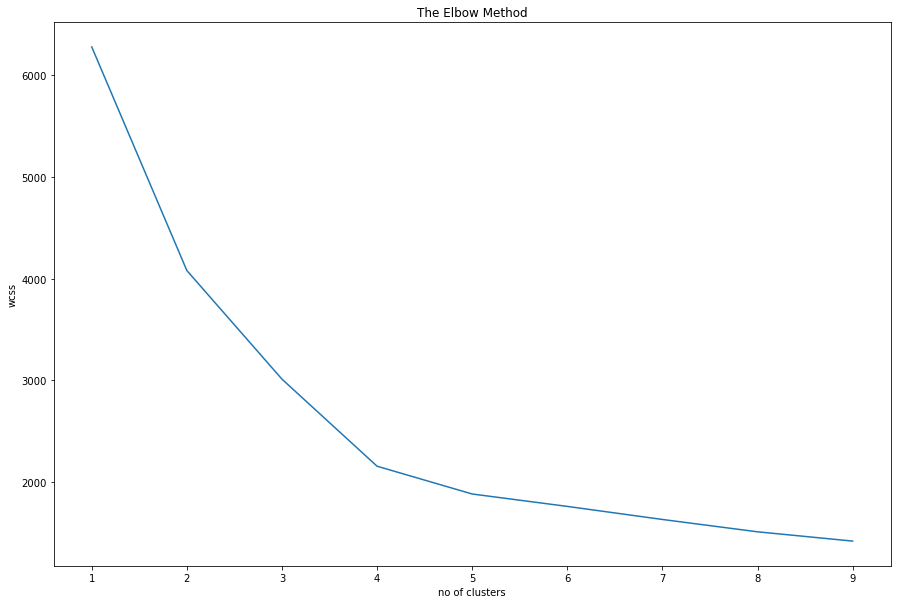

In [36]:
plt.figure(figsize=(15,10))
plt.plot(range(1,10), wcss)
plt.title('The Elbow Method')
plt.xlabel('no of clusters')
plt.ylabel('wcss')
plt.show()

As we see Elbow Method shows that we should get 4 clusters.
But if we want to make sure try kneelocator.

In [37]:
kl = KneeLocator(range(1, 10), wcss, curve="convex", direction="decreasing")
kl.elbow

4

This also showed that 4 clusters are optimal

Now we need to plot this data and see how k-means separate them.

So we should use PCA algorithm to reduction dimension and plot.

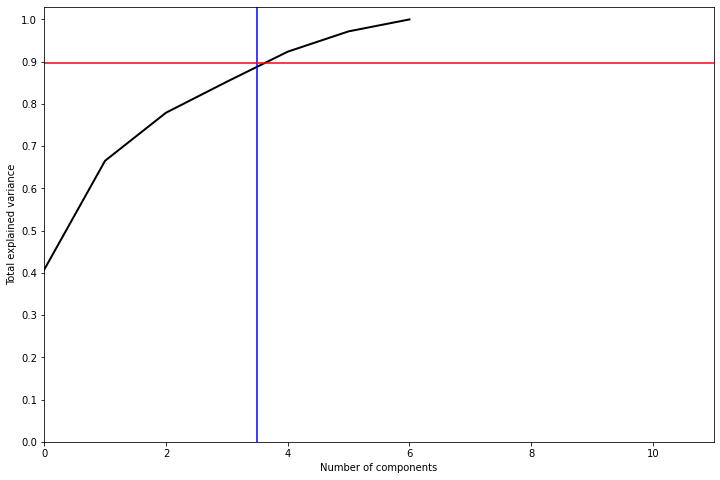

In [38]:
pca = PCA().fit(a_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))

plt.figure(figsize=(12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 11)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(3.5, c='b')
plt.axhline(0.896, c='r')
plt.show()

This plot shows that 2 component is enough to see Data so we will see clearly picture.

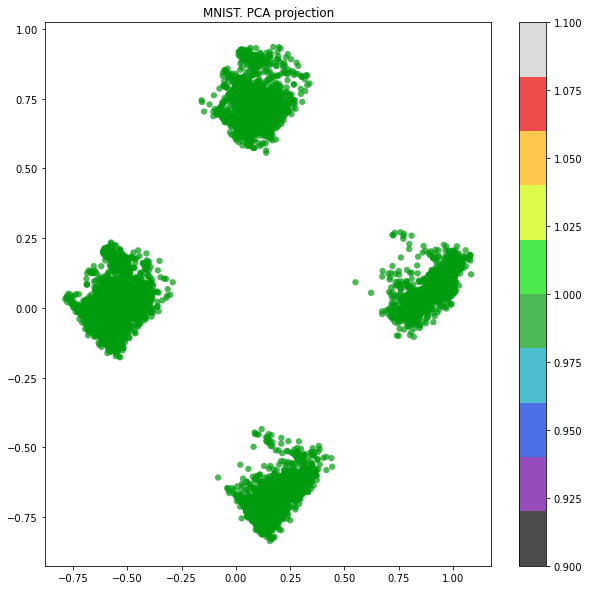

In [39]:
pca = decomposition.PCA(n_components=2)
X_reduced_train = pca.fit_transform(a_train.drop(columns=["ID","Segmentation","Gender","Spending_Score"]))

plt.figure(figsize=(10,10))
plt.scatter(X_reduced_train[:, 0], X_reduced_train[:, 1], c=[1]*a_train.shape[0], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

With this picture we have made sure once again that the number of optimal classes is 4.

It's data distribution and let's see how it would be separated with K-Means.

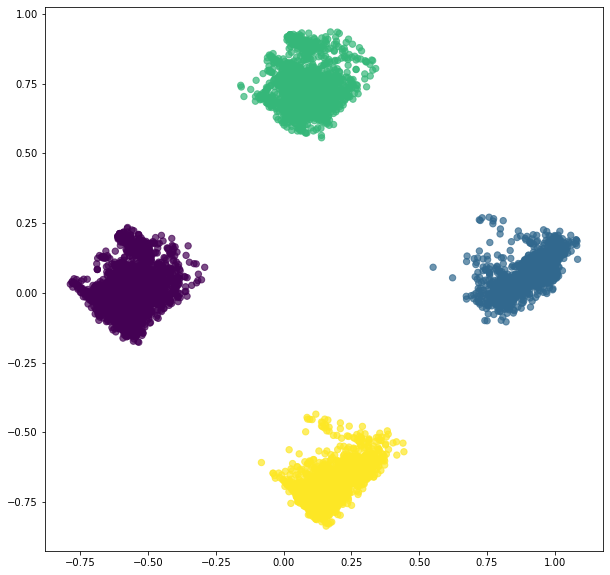

In [40]:
p, ax  = plt.subplots(figsize = (10,10))

kmeansmodel = KMeans(n_clusters= 4, init='k-means++',random_state=0)
y_kmeans_train = kmeansmodel.fit_predict(X_reduced_train)

plt.scatter(X_reduced_train[:,0], X_reduced_train[:,1], c=y_kmeans_train, alpha=0.7, s=40)

# Test Data

For now we can see reporting variables distribution in Test data and compare.

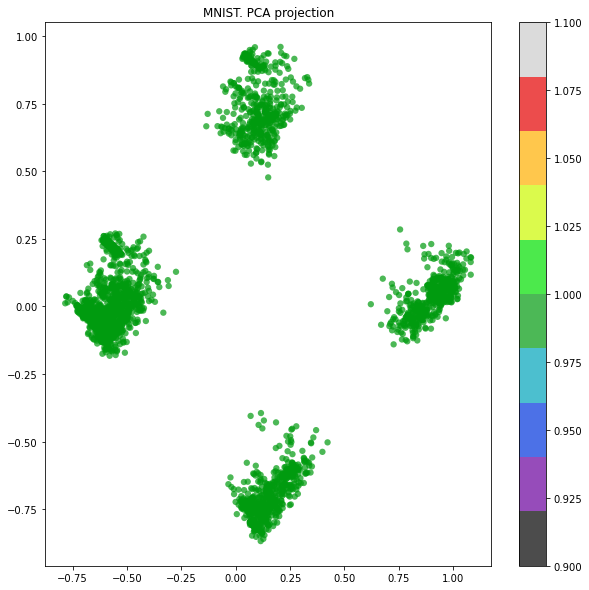

In [41]:
pca = decomposition.PCA(n_components=2)
X_reduced_test = pca.fit_transform(b_test.drop(columns=["ID","Gender","Spending_Score"]))

plt.figure(figsize=(10,10))
plt.scatter(X_reduced_test[:, 0], X_reduced_test[:, 1], c=[1]*b_test.shape[0], 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

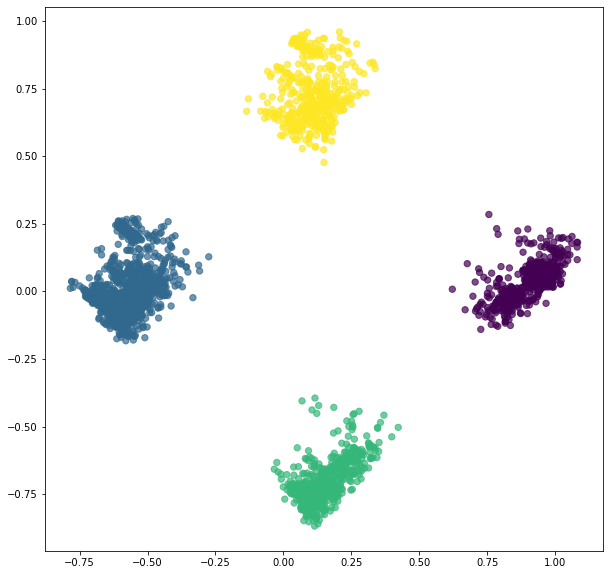

In [42]:
f, ax  = plt.subplots(figsize = (10,10))

kmeansmodel = KMeans(n_clusters= 4, init='k-means++',random_state=0)
y_kmeans_test = kmeansmodel.fit_predict(X_reduced_test)
    
plt.scatter(X_reduced_test[:,0], X_reduced_test[:,1], c=y_kmeans_test, alpha=0.7, s=40)

# As we see test classes are grouped about the same as in the training.

Now we can get the same classes from both the test and training datasets.

Compare the distribution of the reporting variables to the given class.

In [44]:
b_test=b_test.reset_index()
df_kmeans = pd.DataFrame(y_kmeans_test)
df_kmeans.columns = ["k-means_label"]

b_test=pd.concat([b_test,df_kmeans],axis=1)
b_test

,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,k-means_label
0,0,458989,0.0,1.0,0.253521,1.0,0.250,0.000000,1.0,0.000,0.833333,1
1,1,458994,1.0,1.0,0.267606,1.0,0.625,0.571429,0.0,0.375,0.833333,1
2,2,458996,0.0,1.0,0.718310,0.0,0.125,0.000000,1.0,0.000,0.833333,3
3,3,459000,1.0,1.0,0.577465,0.0,0.500,0.785714,0.5,0.125,0.833333,3
4,4,459001,0.0,0.0,0.014085,0.0,1.000,0.142857,1.0,0.375,0.833333,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2616,2622,467954,1.0,0.0,0.154930,0.0,0.625,0.642857,1.0,0.375,0.833333,0
2617,2623,467958,0.0,0.0,0.239437,1.0,0.125,0.071429,1.0,0.000,0.833333,2
2618,2624,467960,0.0,0.0,0.492958,1.0,0.375,0.071429,1.0,0.125,0.833333,2
2619,2625,467961,1.0,1.0,0.408451,1.0,0.500,0.071429,0.5,0.500,0.500000,1


In [45]:
a_train=a_train.reset_index()
df_kmeans = pd.DataFrame(y_kmeans_train)
df_kmeans.columns = ["k-means_label"]

a_train=pd.concat([a_train,df_kmeans],axis=1)
a_train

,index,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,k-means_label
0,0,462809,1.0,0.0,0.056338,0.0,0.625,0.071429,1.0,0.375,0.500000,3,1
1,1,462643,0.0,1.0,0.281690,1.0,0.250,0.357143,0.0,0.250,0.500000,0,0
2,2,466315,0.0,1.0,0.690141,1.0,0.250,0.071429,1.0,0.000,0.833333,1,0
3,3,461735,1.0,1.0,0.690141,1.0,0.875,0.000000,0.5,0.125,0.833333,1,0
4,4,462669,0.0,1.0,0.309859,1.0,0.375,0.357143,0.5,0.625,0.833333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8044,8063,464018,1.0,0.0,0.056338,0.0,0.750,0.000000,1.0,0.750,0.000000,3,1
8045,8064,464685,1.0,0.0,0.239437,0.0,0.500,0.214286,1.0,0.375,0.500000,3,1
8046,8065,465406,0.0,0.0,0.211268,1.0,0.625,0.071429,1.0,0.000,0.833333,3,3
8047,8066,467299,0.0,0.0,0.126761,1.0,0.625,0.071429,1.0,0.375,0.833333,1,3


In [46]:
# This feature gives us classes separately
def get_classes(df,col,rng):
    _classes = []
    
    for i in range(rng):
        _classes.append(df[df[col]==i])
    
    return _classes

In [47]:
test_class_0, test_class_1, test_class_2, test_class_3 = get_classes(b_test,"k-means_label",4)

train_class_0, train_class_1, train_class_2, train_class_3 = get_classes(a_train,"k-means_label",4)

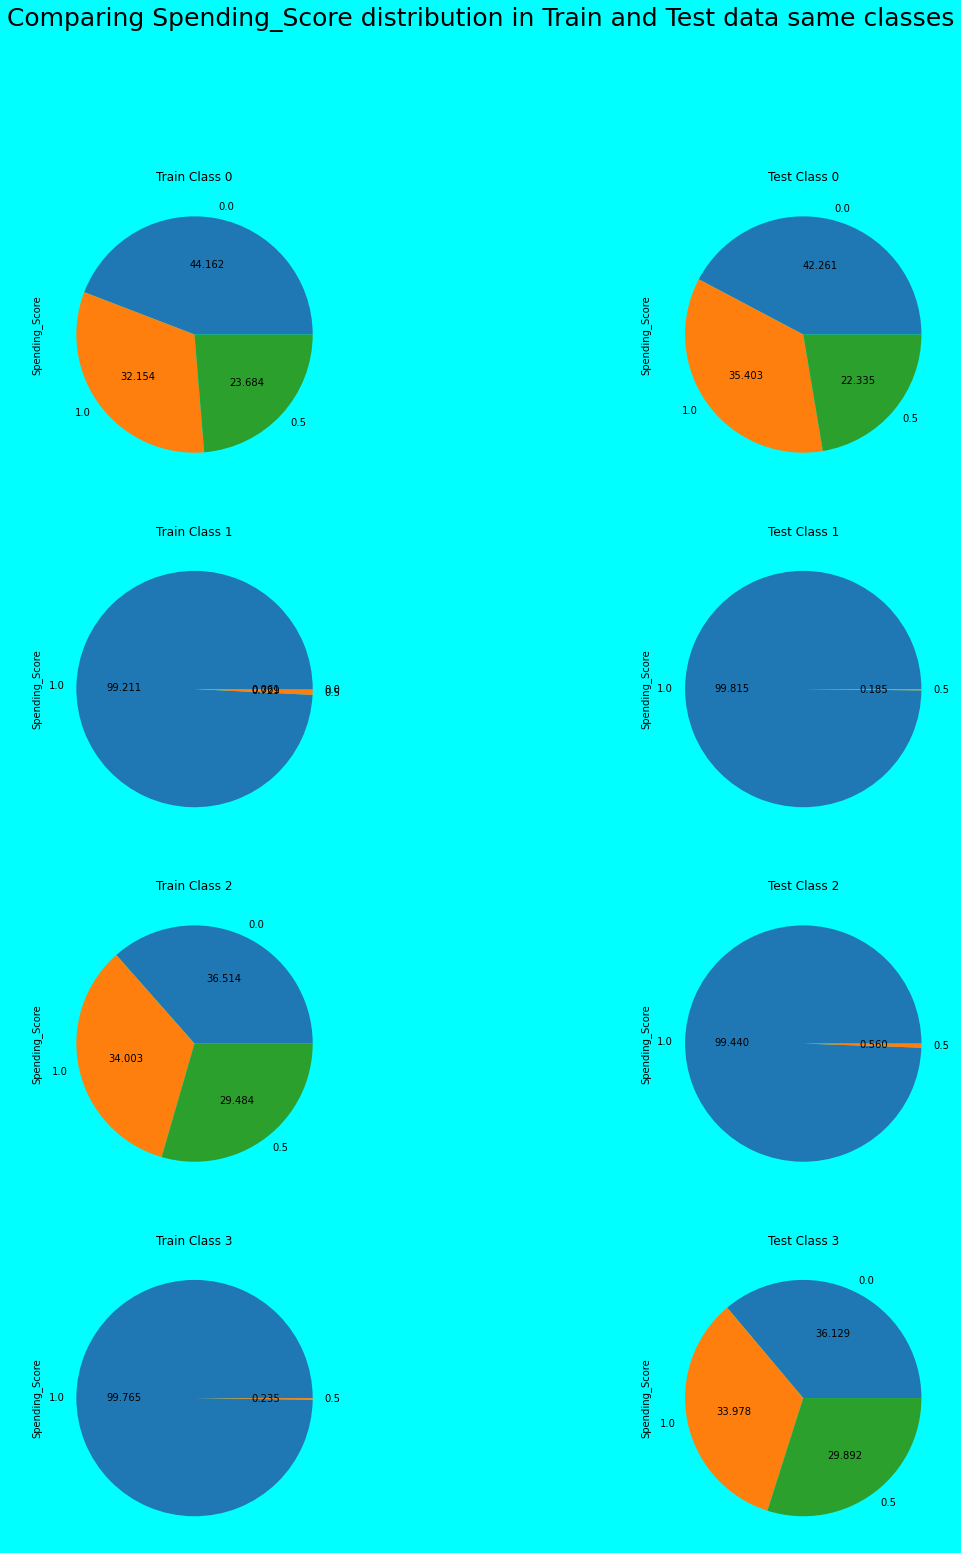

In [52]:
p, ax  = plt.subplots(4,2,figsize = (20,25))
p.suptitle("Comparing Spending_Score distribution in Train and Test data same classes", fontsize=25)

train_class_0['Spending_Score'].value_counts().plot.pie(title='Train Class 0', ax=ax[0][0], autopct="%.3f")
test_class_1['Spending_Score'].value_counts().plot.pie(title='Test Class 0', ax=ax[0][1], autopct="%.3f")

train_class_1['Spending_Score'].value_counts().plot.pie(title='Train Class 1', ax=ax[1][0], autopct="%.3f")
test_class_0['Spending_Score'].value_counts().plot.pie(title='Test Class 1', ax=ax[1][1], autopct="%.3f")

train_class_2['Spending_Score'].value_counts().plot.pie(title='Train Class 2', ax=ax[2][0], autopct="%.3f")
test_class_2['Spending_Score'].value_counts().plot.pie(title='Test Class 2', ax=ax[2][1],autopct="%.3f")

train_class_3['Spending_Score'].value_counts().plot.pie(title='Train Class 3', ax=ax[3][0], autopct="%.3f")
test_class_3['Spending_Score'].value_counts().plot.pie(title='Test Class 3', ax=ax[3][1], autopct="%.3f")

p.patch.set_facecolor('cyan')
plt.show()

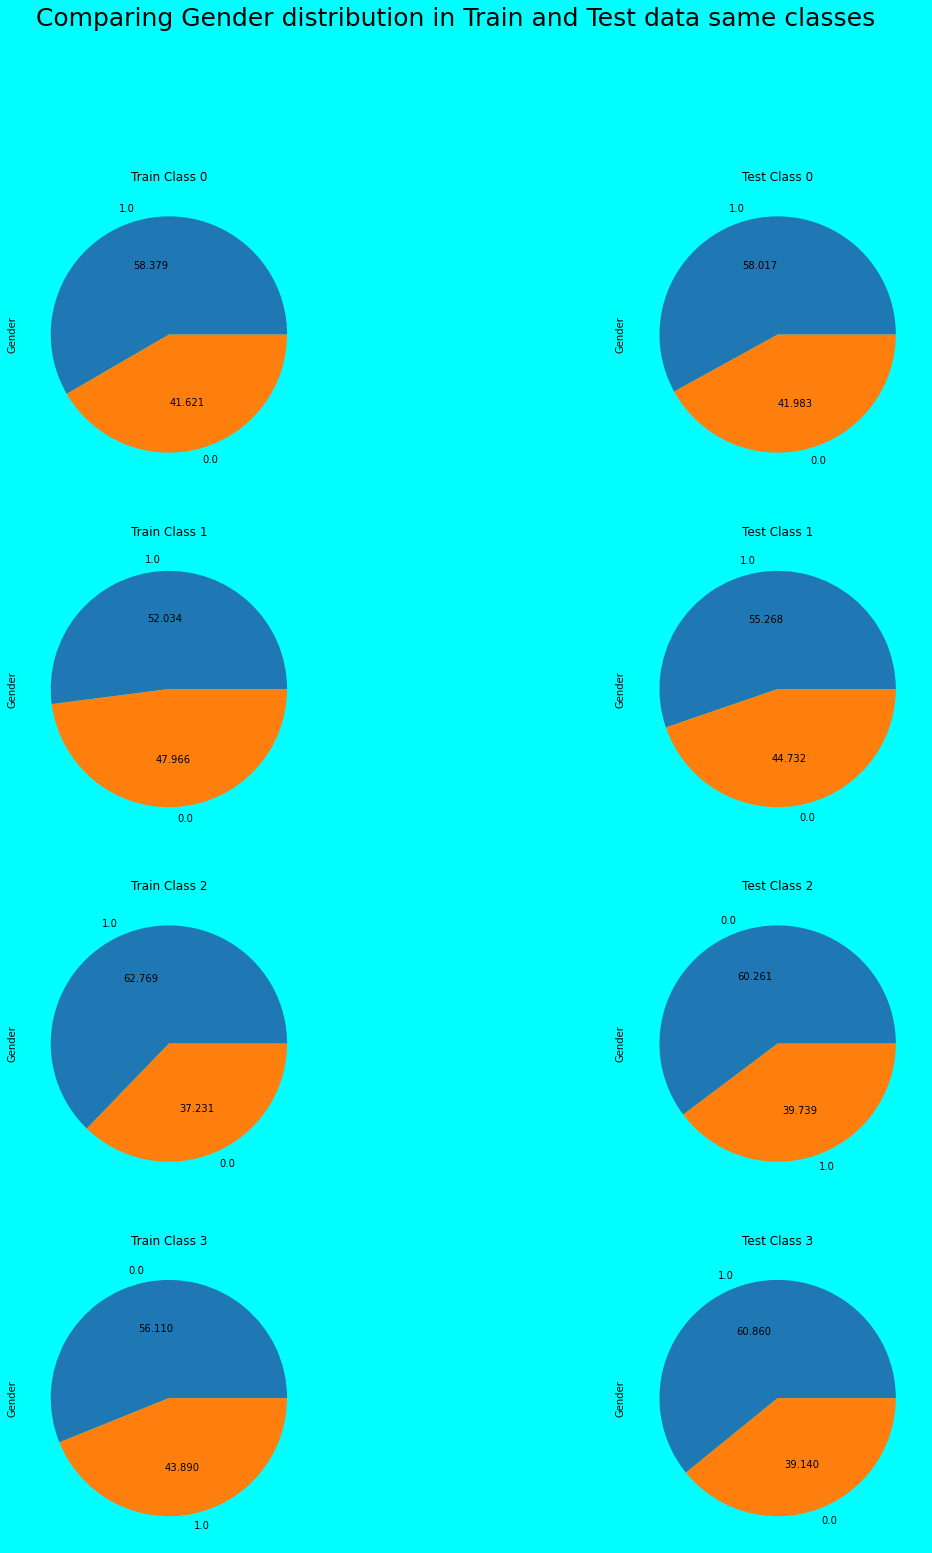

In [54]:
p, ax  = plt.subplots(4,2,figsize = (20,25))
p.suptitle("Comparing Gender distribution in Train and Test data same classes", fontsize=25)

train_class_0['Gender'].value_counts().plot.pie(title='Train Class 0', ax=ax[0][0], autopct="%.3f")
test_class_1['Gender'].value_counts().plot.pie(title='Test Class 0', ax=ax[0][1], autopct="%.3f")

train_class_1['Gender'].value_counts().plot.pie(title='Train Class 1', ax=ax[1][0], autopct="%.3f")
test_class_0['Gender'].value_counts().plot.pie(title='Test Class 1', ax=ax[1][1], autopct="%.3f")

train_class_2['Gender'].value_counts().plot.pie(title='Train Class 2', ax=ax[2][0], autopct="%.3f")
test_class_2['Gender'].value_counts().plot.pie(title='Test Class 2', ax=ax[2][1],autopct="%.3f")

train_class_3['Gender'].value_counts().plot.pie(title='Train Class 3', ax=ax[3][0], autopct="%.3f")
test_class_3['Gender'].value_counts().plot.pie(title='Test Class 3', ax=ax[3][1], autopct="%.3f")

p.patch.set_facecolor('cyan')
plt.show()

# This visualization clearly shows that the distribution of the Report variables in Test and Train Data are the same